In [1]:
%config Completer.use_jedi = False

In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from catboost import CatBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import random
random.seed(0)

from sklearn.impute import SimpleImputer
import shap
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

plt.style.use("seaborn-whitegrid")
rcParams["axes.labelsize"] = 14
rcParams["xtick.labelsize"] = 12
rcParams["ytick.labelsize"] = 12
rcParams["figure.figsize"] = 16, 8
import seaborn as sns
from scipy.stats import kstest

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split


from pytorch_tabnet.tab_model import TabNetRegressor

In [4]:
from NN_files.gauss_rank_scaler import GaussRankScaler
from NN_files.nnet import ReadDataset,ResNet,Net

In [5]:
def explain(pipe,X):

    explainer = shap.Explainer(pipe.named_steps['model'])
    xx = pd.DataFrame(pipe[:-1].transform(X),columns=X.columns)
    shap_values = explainer(xx)

    shap.plots.bar(shap_values)
    shap.plots.beeswarm(shap_values)

In [6]:
data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
subm = pd.read_csv('data/sample_submission.csv')

In [7]:
data.shape

(72000, 14)

In [8]:
data['train']=1
test['train']=0

In [9]:
df = data.append(test)

In [10]:
df = df.drop(columns='id')

In [11]:
df = pd.get_dummies(df,columns=['obs_day'])

In [12]:
# Not working
df['vaps_pres_temp'] = df['vap_pressure']/df['vap_temp']
#data['hour_sin'] = np.sin(2 * np.pi * data['obs_hour']/23.0)
#data['hour_cos'] = np.cos(2 * np.pi * data['obs_hour']/23.0)
df['vol'] = df['vap_temp']/df['vap_pressure']
df['vol_div'] = df['vap_temp']/df['vap_pressure_div']

# Inverse
df["vap_temp_inv"] = df["vap_temp"] ** -1
df["vap_pressure"] = df["vap_pressure"] ** -1
df["vap_enth"] = df["vap_enth"] ** -1
df["vap_pressure_div"] = df["vap_pressure_div"] ** -1
df["vap_motion"] = df["vap_motion"] ** -1
df['faucet_hole'] = df['faucet_hole']**-1

In [13]:
df

,obs_hour,obs_minute,C_motion,fw_motion,faucet_hole,vap_pressure,vap_enth,vap_pressure_div,vap_motion,fw_enth,vap_temp,output_gen,train,obs_day_Friday,obs_day_Saturday,vaps_pres_temp,vol,vol_div,vap_temp_inv
0,5.0,46.0,361.486145,2542.801078,1.499523,0.041428,0.000359,0.039295,0.000393,1270.066040,603.834106,930.271729,1,0,1,0.039975,25.015661,23.727924,0.001656
1,18.0,NaN,197.064667,1454.458144,NaN,0.078723,NaN,0.074598,0.000688,1095.314453,500.178772,473.562103,1,0,1,0.025397,39.375486,37.312534,0.001999
2,3.0,51.0,356.869232,2458.671690,1.473438,NaN,0.000359,NaN,0.000407,1262.656982,603.529663,904.269897,1,0,1,NaN,NaN,NaN,0.001657
3,13.0,NaN,239.267517,1628.127295,1.472457,0.065028,0.000347,0.061528,0.000615,1148.203857,593.649658,597.799194,1,0,1,0.025904,38.603699,36.526127,0.001684
4,11.0,13.0,NaN,2621.829401,1.478409,0.040787,0.000359,NaN,0.000381,1280.567383,602.601501,950.284973,1,1,0,0.040686,24.578225,NaN,0.001659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,11.0,25.0,236.904633,1741.410339,1.550823,0.057924,0.000341,0.055122,0.000575,1171.553711,598.504211,NaN,0,0,1,0.028845,34.667658,32.990657,0.001671
47996,13.0,NaN,233.311859,1639.089412,1.499205,0.063478,0.000347,0.060205,0.000609,1150.022949,588.658203,NaN,0,0,1,0.026762,37.366562,35.440129,0.001699
47997,10.0,17.0,364.628662,2596.038249,1.515033,0.040107,0.000359,0.038082,0.000385,1280.458618,602.522888,NaN,0,1,0,0.041382,24.165330,22.945005,0.001660
47998,11.0,12.0,370.186768,2623.624449,NaN,0.040676,0.000359,NaN,0.000382,1280.452148,602.867676,NaN,0,1,0,0.040779,24.522346,NaN,0.001659


In [14]:
# Might work
df['vol_pres'] = df['vap_pressure']/df['vap_enth']
df['vol_pres_div'] = df['vap_pressure_div']/df['vap_enth']

df['motion_times_vap'] = df['fw_motion'] * df['vap_pressure_div']
df['motion_by_vap'] = df['fw_motion'] / df['vap_pressure_div']
df['motion_by_vap_inv'] = (df['fw_motion'] / df['vap_pressure_div'])**-1

df['vap_dif'] = df['vap_pressure'] - df['vap_pressure_div']

# Machine Learning

In [15]:
imp = SimpleImputer(strategy='mean')
df = pd.DataFrame(imp.fit_transform(df),columns = df.columns)

In [16]:
data = df[df['train']==1]
test = df[df['train']==0]

In [17]:
X = data.drop(columns=["train", "output_gen"])
y = data["output_gen"]

In [18]:
X = pd.DataFrame(GaussRankScaler().fit_transform(X,y),columns= X.columns)

In [19]:
X_tr, X_te, y_tr, y_te = train_test_split(
    X,y,random_state=0
)

In [20]:
trainset = ReadDataset(X_tr,y_tr.values)
testset = ReadDataset(X_te,y_te.values)


# Data loaders
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)

In [21]:
X_train = torch.tensor(trainset.X.values)
y_train = torch.tensor(trainset.y)

X_test = torch.tensor(testset.X.values)
y_test = torch.tensor(testset.y)

In [22]:

# Use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
# Neural Network
nnet = ResNet(trainset.__shape__()).to(device)

In [24]:
# Optimizer
optimizer = optim.Adam(
    nnet.parameters(), lr=0.00001, betas=(0.9, 0.999), eps=1e-08,  # weight_decay=0.0001
)

In [25]:

# Train the net
loss_per_iter = []
loss_per_batch = []


# Train the net
losses = []
metric_test = []
metric_train = []
auc_train = []
auc_test = []
metric_val = []
unc_val = []

0


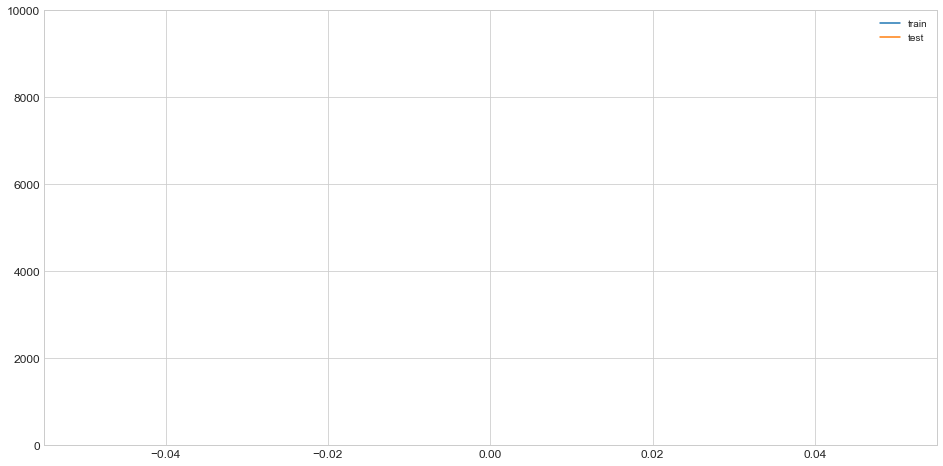

5


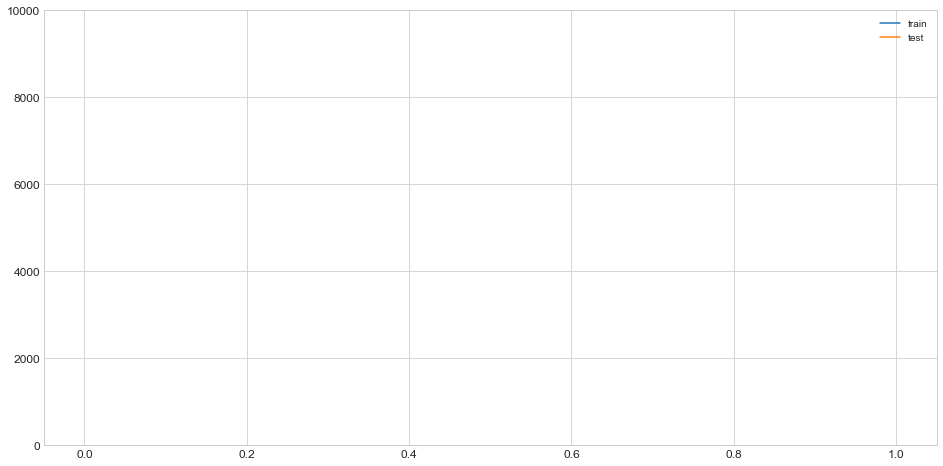

10


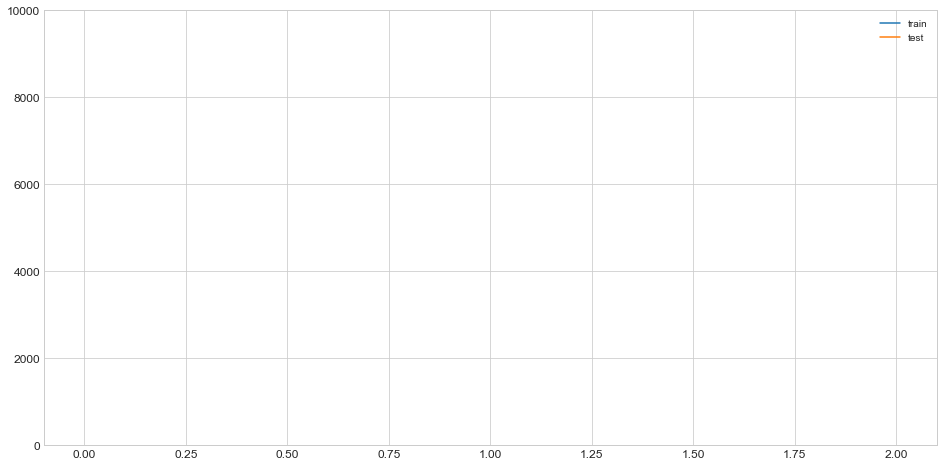

15


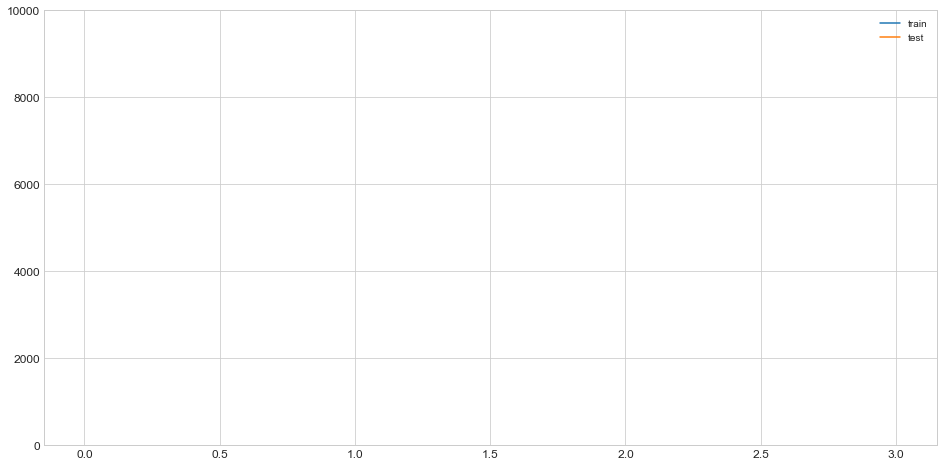

20


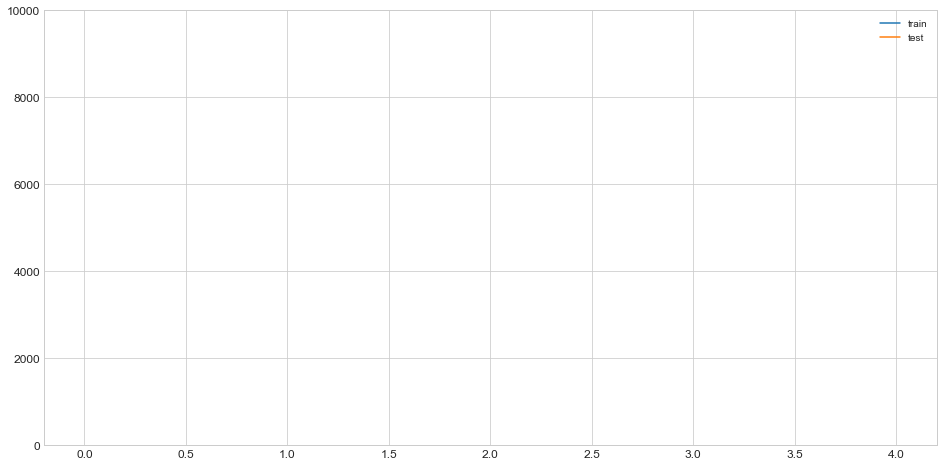

In [ ]:
# hyperparameteres
n_epochs = 100

for epoch in range(n_epochs):

    for i, (inputs, labels) in enumerate(trainloader):
        X = inputs.to(device)
        y = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forwarde
        outputs = nnet(X.float())

        # Compute diff
        criterion = nn.MSELoss()
        loss = criterion(outputs, y.float())

        # Compute gradient
        loss.backward(retain_graph=True)

        # update weights
        optimizer.step()

        # Save loss to plot

        losses.append(loss.item())

    if epoch % 5 == 0:
        print(epoch)
        pred = nnet(X_test.float())
        metric_test.append(mean_squared_error(pred.detach().numpy(),y_te,squared=True))
        
        pred = nnet(X_train.float())
        metric_train.append(mean_squared_error(pred.detach().numpy(),y_tr,squared=True))

        # Figure
        plt.figure()
        plt.plot(metric_train, label="train")
        plt.plot(metric_test, label="test")
        plt.legend()
        plt.ylim([0,10_000])
        plt.show()

        #
        path = "output/weights" + str(epoch) + ".pt"
        torch.save(nnet.state_dict(), path)

print("Elapsed time: ", np.abs(tic - time.time()))
print("done")

In [ ]:
mean_squared_error()